In [1]:
import sparknlp
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from helper import *
from pyspark.ml import PipelineModel
from pyspark.ml.feature import CountVectorizerModel, IDFModel
from pyspark.sql import SparkSession
from sklearn.decomposition import LatentDirichletAllocation
from pyspark.ml.clustering import LocalLDAModel, LDA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Set up

Initialise SparkSpession

In [2]:
# If run sparknlp, use this
sparknlp_session = sparknlp.start(params={"spark.driver.host": "localhost",
                                          "spark.driver.port": "9999",
                                          "spark.driver.bindAddress": "127.0.0.1",
                                          "spark.driver.maxResultSize": "2g"})

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", sparknlp_session.version)
# sparknlp_session.stop()

:: loading settings :: url = jar:file:/Users/lam.nguyen/Desktop/GithubClone/BigData_Final/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/lam.nguyen/.ivy2/cache
The jars for the packages stored in: /Users/lam.nguyen/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-74cda493-7f09-4624-97c0-5db67cec334b;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.0.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500

Spark NLP version:  6.0.0
Apache Spark version:  3.5.5


In [2]:
# # If run PySpark, use this
# spark = SparkSession.builder\
#         .appName("Nhom09_PySparkLDA")\
#         .master("local[*]")\
#         .config("spark.driver.bindAddress", "localhost")\
#         .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/05 23:19:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Load data

In [3]:
corpus = pd.read_json(os.path.join("..", "data", "merged", "corpus.json"))
# corpus_ps = sparknlp_session.createDataFrame(corpus)

Train a pyspark Pipeline, TF and IDF model

In [4]:
# train_pipeline, train_tf, train_idf = pipeline_model(train_data=corpus.copy(deep=True),    
#                                                      spark_session=sparknlp_session)
# train_pipeline.save(os.path.join("..", "model", "pipeline"))
# train_tf.save(os.path.join("..", "model", "tf"))
# train_idf.save(os.path.join("..", "model", "idf"))

25/05/04 22:25:21 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]

25/05/04 22:26:39 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/05/04 22:26:39 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[ — ]

[OK!]


25/05/04 22:26:51 WARN TaskSetManager: Stage 2 contains a task of very large size (52730 KiB). The maximum recommended task size is 1000 KiB.
25/05/04 22:38:38 WARN TaskSetManager: Stage 3 contains a task of very large size (52730 KiB). The maximum recommended task size is 1000 KiB.
25/05/04 22:38:40 WARN TaskSetManager: Stage 4 contains a task of very large size (52730 KiB). The maximum recommended task size is 1000 KiB.
25/05/04 22:38:50 WARN TaskSetManager: Stage 8 contains a task of very large size (52730 KiB). The maximum recommended task size is 1000 KiB.


Load trained model

In [4]:
pipeline_path = os.path.join("..", "model", "pipeline")
tf_path = os.path.join("..", "model", "tf")
idf_path = os.path.join("..", "model", "idf")

pipeline = PipelineModel.load(pipeline_path)
tf = CountVectorizerModel.load(tf_path)
idf = IDFModel.load(idf_path)

25/05/05 23:22:16 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
25/05/05 23:22:19 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


Extract features

In [ ]:
# # preprocess using nltk
# corpus_nltk, tfidf_nltk = preprocess_nltk(data=corpus.copy(deep=True))

In [5]:
# Extract features (using SparkNLP)
tfidf_ps = preprocess_sparknlp(data=corpus.copy(deep=True), # PySpark DataFrame
                               spark_session=sparknlp_session,
                               tfidf_model=(tf, idf),
                               pipeline_model=pipeline)

In [3]:
# # Extract features (using nltk)
# tfidf_nltk = pd.read_json(os.path.join("..", "data", "processed", "features_nltk.json"))

# Evaluation

## NTLK preprocessing vs SparkNLP preprocessing

In [17]:
# num_rows = [row for row in range(1000, 11000, 1000)]
# num_rows

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [7]:
# # Load SparkNLP trained PipelineModel
# pipeline_path = os.path.join("..", "model", "pipeline")
# tf_path = os.path.join("..", "model", "tf")
# idf_path = os.path.join("..", "model", "idf")

# pipeline = PipelineModel.load(pipeline_path)
# tf = CountVectorizerModel.load(tf_path)
# idf = IDFModel.load(idf_path)


25/05/04 12:31:19 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
25/05/04 12:31:21 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [10]:
# nltk_time = []
# sparknlp_time = []
# for row in num_rows:
#     subset_df = corpus.copy(deep=True).head(row)
#     # NLTK time
#     nltk_start = time.time()
#     nlkt_result = preprocess_nltk(data=subset_df)
#     nltk_end = time.time()
#     nltk_time.append(nltk_end - nltk_start)

#     # SparkNLP time
#     sparknlp_start = time.time()
#     sparknlp_result = preprocess_sparknlp(data=subset_df,
#                                           spark_session=sparknlp_session,
#                                           tfidf_model=(tf, idf),
#                                           pipeline_model=pipeline)
#     sparknlp_end = time.time()
#     sparknlp_time.append(sparknlp_end - sparknlp_start)

In [14]:
# time_df = pd.read_csv(os.path.join("..", "evaluation_result", "nltk_sparknlp.csv"))
# time_df[['nltk', 'sparknlp']] = time_df[['nltk', 'sparknlp']].astype(int)
# time_df

,nltk,sparknlp
0,63,13
1,115,22
2,174,33
3,230,48
4,296,57
5,347,67
6,408,79
7,456,87
8,510,130
9,642,116


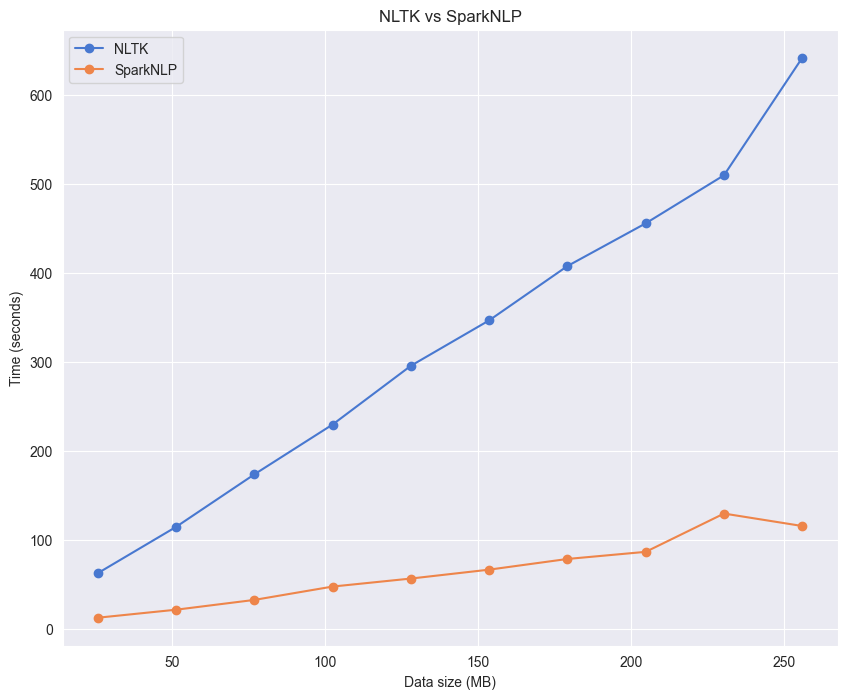

In [54]:
# # Plotting 
# paper_size = 0.02561 # 10000 papers has a total of 256,1MB
# horizontal_axis = [num_papers*paper_size for num_papers in num_rows]
# plt.figure(figsize=(10, 6))
# sns.set_palette(sns.color_palette("muted"))
# sns.set_style('darkgrid')
# plt.plot(horizontal_axis, time_df['nltk'], label='NLTK', marker='o')
# plt.plot(horizontal_axis, time_df['sparknlp'], label='SparkNLP', marker='o')
# plt.xlabel('Data size (MB)')
# plt.ylabel('Time (seconds)')
# plt.title('NLTK vs SparkNLP')
# plt.legend()
# plt.grid(True)
# # plt.savefig(os.path.join("..", "img", 'nltk_sparknlp.png'), format='png', dpi=500)
# plt.show()

## Throughput, time, speedup when use PySpark vs Scikit-learn to train model

In [4]:
# num_rows = [row for row in range(1000, 11000, 1000)]
# num_rows

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [5]:
# num_topics = 5
# max_iter = 10

In [ ]:
# subset_df = [pd.read_csv(os.path.join("..", "data", "throughput_cal", str(row) + ".csv"), index_col=0) for row in num_rows]
# subset_ps = []
# for row in num_rows:
#     path = os.path.join("..", "data", "throughput_cal", str(row) + ".csv")
#     tmp_df = pd.read_csv(os.path.join("..", "data", "throughput_cal", str(row) + ".csv"))

#     row_objects = [
#         Row(tf_idf_features=Vectors.dense(vec)) for vec in tmp_df.values
#     ]
#     tfidf = spark.createDataFrame(row_objects)
#     subset_ps.append(tfidf)

In [ ]:
# subset_df = [tfidf_nltk.copy(deep=True).head(row) for row in num_rows]
# subset_ps = []
# for df in subset_df:
#     tmp = [
#         Row(tf_idf_features=Vectors.dense(vec)) for vec in df.values
#     ]
#     tfidf = sparknlp_session.createDataFrame(tmp)
#     subset_ps.append(tfidf)

In [7]:
# import sys
# input_size = [sys.getsizeof(df) for df in subset_df]

[3352016,
 6704016,
 10056016,
 13408016,
 16760016,
 20112016,
 23464016,
 26816016,
 30168016,
 33520016]

In [14]:
# sklearn_time = []
# pyspark_time = []
# for i in range(len(num_rows)):
#     # scikit-learn time
#     sklearn_start = time.time()
#     sklearn_model = LatentDirichletAllocation(n_components=num_topics, 
#                                               max_iter=max_iter)
#     sklearn_model.fit(subset_df[i])
#     sklearn_end = time.time()
#     sklearn_time.append(sklearn_end - sklearn_start)

#     # pyspark time
#     pyspark_start = time.time()
#     pyspark_model = LDA(k=num_topics, 
#                         maxIter=max_iter, 
#                         featuresCol='tf_idf_features')
#     pyspark_model.fit(subset_ps[i])
#     subset_ps[i].unpersist()
#     pyspark_end = time.time()
#     pyspark_time.append(pyspark_end - pyspark_start)

#     print(f"First {num_rows[i]} is complete")
#     print(f"pyspark: {pyspark_end - pyspark_start} - sklearn {sklearn_end - sklearn_start}")


First 1000 is complete
pyspark: 1.4593920707702637 - sklearn 5.064054012298584


25/05/05 08:38:26 WARN TaskSetManager: Stage 242 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 243 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 244 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 245 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 246 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 247 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 248 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.

First 2000 is complete
pyspark: 1.7062091827392578 - sklearn 9.010257005691528


25/05/05 08:38:41 WARN TaskSetManager: Stage 264 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 265 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 266 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 267 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 268 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 269 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 270 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.

First 3000 is complete
pyspark: 1.8465158939361572 - sklearn 14.066035985946655


25/05/05 08:39:02 WARN TaskSetManager: Stage 286 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 287 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 288 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 289 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 290 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:03 WARN TaskSetManager: Stage 291 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:03 WARN TaskSetManager: Stage 292 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.

First 4000 is complete
pyspark: 2.153738021850586 - sklearn 18.35744571685791


25/05/05 08:39:28 WARN TaskSetManager: Stage 308 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 309 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 310 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 311 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 312 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 313 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 314 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.

First 5000 is complete
pyspark: 2.686095952987671 - sklearn 23.97981071472168


25/05/05 08:40:00 WARN TaskSetManager: Stage 330 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 331 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 332 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 333 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 334 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 335 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 336 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.

First 6000 is complete
pyspark: 3.050767183303833 - sklearn 29.715411901474


25/05/05 08:40:35 WARN TaskSetManager: Stage 352 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 353 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 354 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 355 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 356 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 357 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:37 WARN TaskSetManager: Stage 358 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.

First 7000 is complete
pyspark: 3.5251970291137695 - sklearn 32.06306195259094


25/05/05 08:41:19 WARN TaskSetManager: Stage 374 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 375 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 376 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 377 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 378 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:22 WARN TaskSetManager: Stage 379 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:22 WARN TaskSetManager: Stage 380 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.

First 8000 is complete
pyspark: 6.760176181793213 - sklearn 40.583986043930054


25/05/05 08:42:10 WARN TaskSetManager: Stage 396 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 397 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 398 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 399 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 400 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 401 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 402 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.

First 9000 is complete
pyspark: 2.7346110343933105 - sklearn 43.801127910614014


25/05/05 08:43:07 WARN TaskSetManager: Stage 418 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 419 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 420 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 421 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 422 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 423 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:09 WARN TaskSetManager: Stage 424 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.

First 10000 is complete
pyspark: 3.731799840927124 - sklearn 54.37480092048645


In [15]:
# sample_size = round(sys.getsizeof(tfidf_nltk.iloc[:,0])/(1024**2),2) #size of one sample

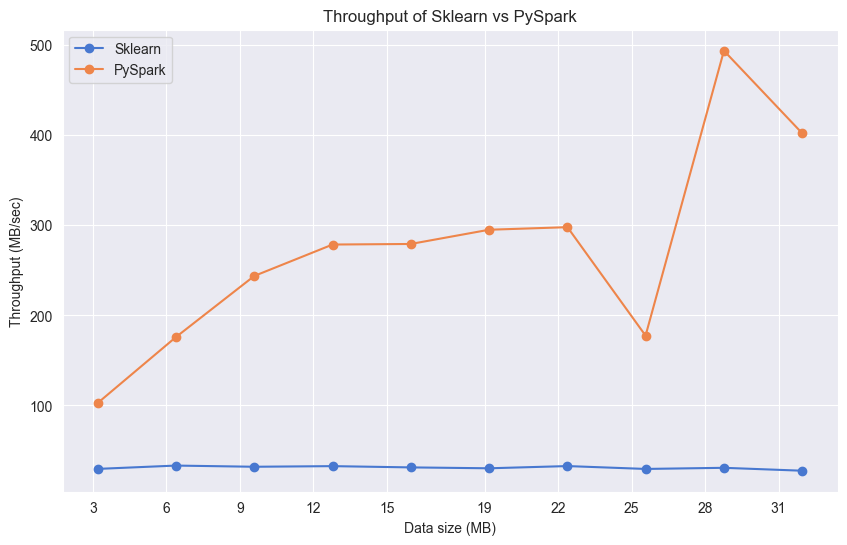

In [17]:
# # Plotting 
# throughput_sklearn = [round(num_rows[i]/sklearn_time[i]*sample_size,2) for i in range(len(num_rows))]
# throughput_pyspark = [round(num_rows[i]/pyspark_time[i]*sample_size,2) for i in range(len(num_rows))]
# horizontal_axis = [round(size/(1024**2),2) for size in input_size]

# plt.figure(figsize=(10, 6))
# sns.set_palette(sns.color_palette("muted"))
# sns.set_style('darkgrid')
# plt.plot(horizontal_axis, throughput_sklearn, label='Sklearn', marker='o')
# plt.plot(horizontal_axis, throughput_pyspark, label='PySpark', marker='o')
# plt.xlabel('Data size (MB)')
# plt.ylabel('Throughput (MB/sec)')
# plt.title('Throughput of Sklearn vs PySpark')
# plt.xticks([int(size) for size in horizontal_axis])
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join("..", "img", 'sklearn_pyspark_throughput.png'), format='png', dpi=500)
# plt.show()

In [21]:
# speedup = [throughput_sklearn[i]/throughput_pyspark[i] for i in range(len(throughput_sklearn))]
# speedup

[0.28818836349484334,
 0.1893874765398396,
 0.1312679524004924,
 0.11730500017947522,
 0.11202635914332784,
 0.10267448561065727,
 0.10995098368360974,
 0.16658216438510506,
 0.06243036846476391,
 0.06864037815648713]

/var/folders/ks/tcmmkdsn54j_lc0yv7dzh4sc0000gp/T/ipykernel_3116/203693749.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


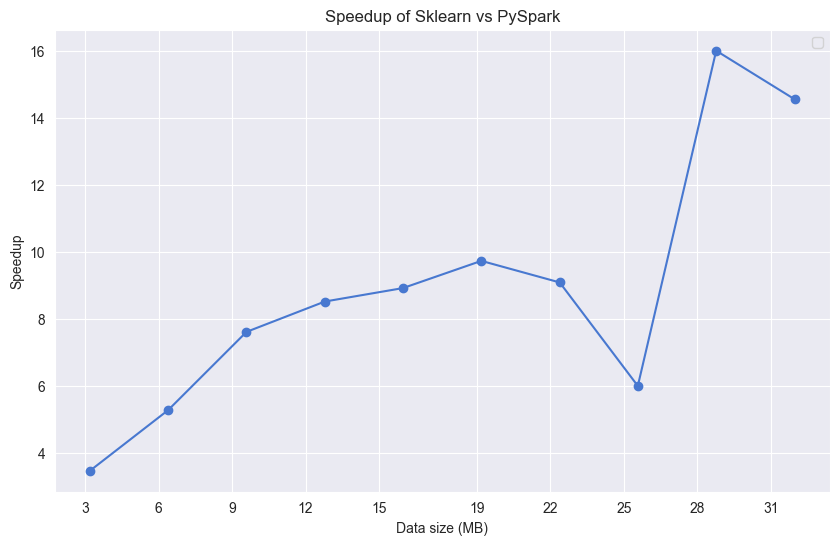

In [23]:
# # Plotting 
# speedup = [throughput_pyspark[i] / throughput_sklearn[i] for i in range(len(throughput_sklearn))]
# horizontal_axis = [round(size/(1024**2),2) for size in input_size]

# plt.figure(figsize=(10, 6))
# sns.set_palette(sns.color_palette("muted"))
# sns.set_style('darkgrid')
# plt.plot(horizontal_axis, speedup, marker='o')
# plt.xlabel('Data size (MB)')
# plt.ylabel('Speedup')
# plt.title('Speedup of Sklearn vs PySpark')
# plt.xticks([int(size) for size in horizontal_axis])
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join("..", "img", 'sklearn_pyspark_speedup.png'), format='png', dpi=500)
# plt.show()

## Algorithm performance: Coherence (PMI) and Diversity (PUW)

In [6]:
num_topics = 10
max_iter = 10

In [7]:
# lda_model = LDA(k=num_topics, 
#                     maxIter=max_iter, 
#                     featuresCol='tf_idf_features')
# lda = lda_model.fit(tfidf_ps)
# # lda.save(os.path.join("..", "model", "lda"))

In [7]:
lda = LocalLDAModel.load(os.path.join("..","model", "lda"))

In [8]:
corpus_profile = lda.transform(tfidf_ps)

In [9]:
term_indices = lda.describeTopics(10).select("topic", "termIndices").collect()
term_indices

[Row(topic=0, termIndices=[16, 63, 0, 120, 1, 99, 283, 90, 65, 235]),
 Row(topic=1, termIndices=[2, 3, 86, 173, 57, 221, 16, 136, 209, 90]),
 Row(topic=2, termIndices=[4, 3, 2, 29, 56, 71, 72, 74, 114, 48]),
 Row(topic=3, termIndices=[2, 3, 98, 114, 131, 44, 11, 32, 56, 58]),
 Row(topic=4, termIndices=[0, 25, 1, 9, 108, 43, 175, 51, 128, 125]),
 Row(topic=5, termIndices=[11, 82, 157, 31, 214, 132, 266, 143, 58, 14]),
 Row(topic=6, termIndices=[23, 25, 72, 129, 56, 9, 4, 27, 188, 74]),
 Row(topic=7, termIndices=[29, 84, 40, 131, 25, 44, 32, 82, 56, 52]),
 Row(topic=8, termIndices=[11, 153, 238, 76, 66, 222, 311, 118, 319, 289]),
 Row(topic=9, termIndices=[86, 218, 19, 136, 46, 44, 1, 82, 16, 166])]

In [10]:
tokens = corpus_profile.select('finish').collect()

25/05/05 23:23:51 WARN TaskSetManager: Stage 29 contains a task of very large size (52730 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 23:32:26 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 388984 ms exceeds timeout 120000 ms
25/05/05 23:32:26 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/05 23:32:32 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(Bloc

KeyboardInterrupt: 

25/05/05 23:38:32 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [50]:
# tf_tmp = tf.transform(pipeline.transform(sparknlp_session.createDataFrame(corpus.copy(deep=True))))

In [41]:
# Calculate PMI
## Get word_frequency and word_frequency_documents
word_frequency = {word: 0 for word in tf.vocabulary}
word_frequency_documents = {word: set() for word in tf.vocabulary}
num_docs = len(corpus)
for i in range(len(tokens)): 
    for word in tokens[i]['finish']:
        if word in tf.vocabulary:
            word_frequency[word] += 1
            # word_frequency_documents[word].add(i)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Users/lam.nguyen/Desktop/GithubClone/BigData_Final/.venv/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/lam.nguyen/Desktop/GithubClone/BigData_Final/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/local/Cellar/python@3.10/3.10.17/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socket.py", line 717, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(word_frequency).to_csv(os.path.join("..", "word_frequency.csv"))
pd.DataFrame(word_frequency_documents).to_csv(os.path.join("..", "word_frequency_documents.csv"))

In [54]:
import numpy as np
def pmi(
        topic_words: list[str],
        word_frequency: dict[int],
        word_frequency_documents: dict[str, list],
        n_docs: int
) -> float:
    """Calculates PMI for a topic
    
    Args:
        topic_words: word representation of a topic
        word_frequency: frequency of each word in corpus
        word_frequency_documents: frequency of each word for each document
        n_docs: number of documents
        
    Returns:
        The PMI metric for the topic"""
    num_topwords = len(topic_words)
    pmi = 0.0

    for j in range(1, num_topwords):
        for i in range(0, j):
            ti = topic_words[i]
            tj = topic_words[j]

            freq_i = word_frequency[ti]
            freq_j = word_frequency[tj]
            freq_ij = len(word_frequency_documents[ti].intersection(word_frequency_documents[tj]))

            wij_prob = freq_ij / float(num_docs)
            wi_wj_prob = ((freq_i*freq_j) / float(num_docs) **2)

            pmi += np.log(wij_prob / wi_wj_prob)

    return pmi